In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **Import Libraries**

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from scipy.stats import ttest_rel

# **Step 1: Set up Kaggle API authentication**

In [4]:
try:
    api = KaggleApi()
    api.authenticate()
except OSError:
    print("kaggle.json not found. Attempting environment variable authentication.")
    os.environ['KAGGLE_USERNAME'] = 'your_username'
    os.environ['KAGGLE_KEY'] = 'your_api_key'
    try:
        api = KaggleApi()
        api.authenticate()
        print("Authenticated using environment variables.")
    except Exception as e:
        print(f"Authentication failed: {e}")
        print("Please set up kaggle.json or environment variables: https://github.com/Kaggle/kaggle-api/")
        raise SystemExit

# **Step 2: Download the dataset from Kaggle**

In [5]:
dataset = 'nelgiriyewithana/credit-card-fraud-detection-dataset-2023'
download_path = './credit-card-fraud-detection-dataset-2023.zip'

try:
    api.dataset_download_files(dataset, path='./', unzip=False)
    print("Dataset downloaded successfully.")
except Exception as e:
    print(f"Failed to download dataset: {e}")
    raise SystemExit

# Unzip the file
try:
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall('./')
    data_path = './creditcard_2023.csv'
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully. Shape:", df.shape)
    display(df.head())
except Exception as e:
    print(f"Error unzipping or loading dataset: {e}")
    raise SystemExit

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
Dataset downloaded successfully.
Dataset loaded successfully. Shape: (568630, 31)


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


# **Step 3: Descriptive Statistics and Initial Visualizations**


Descriptive Statistics for Key Features:
             Amount                     V1                 V2          
               mean          std      mean      std      mean       std
Class                                                                  
0      12026.313506  6929.500715  0.505761  0.82378 -0.491878  0.699694
1      12057.601763  6909.750891 -0.505761  0.89989  0.491878  1.013186

Class Distribution:
Class
0    50.0
1    50.0
Name: proportion, dtype: float64


/tmp/ipython-input-582915165.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="muted")


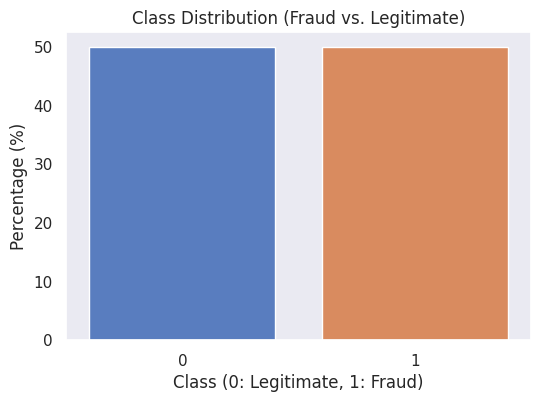

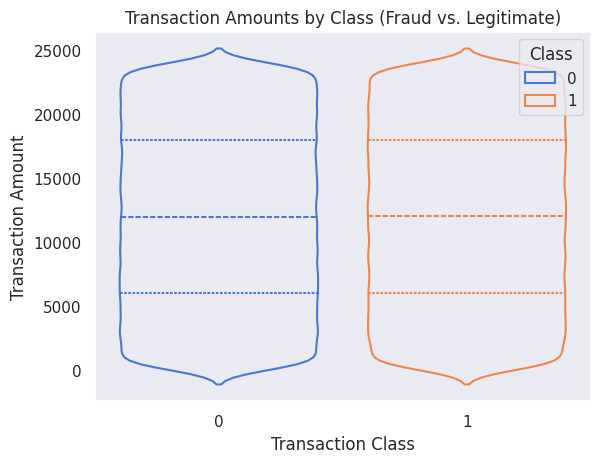

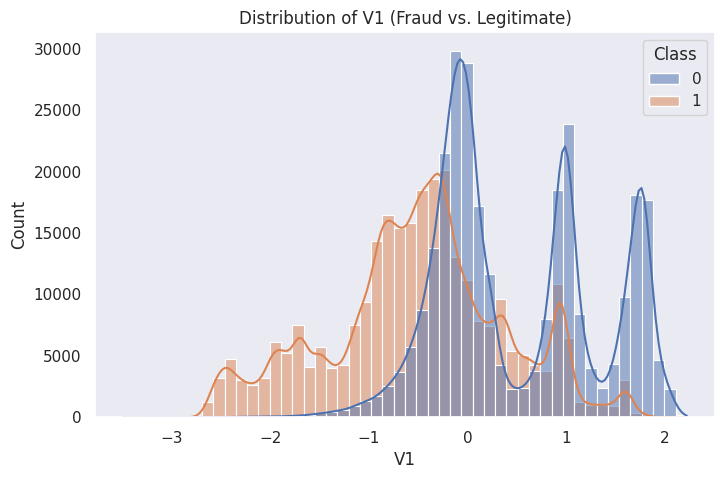

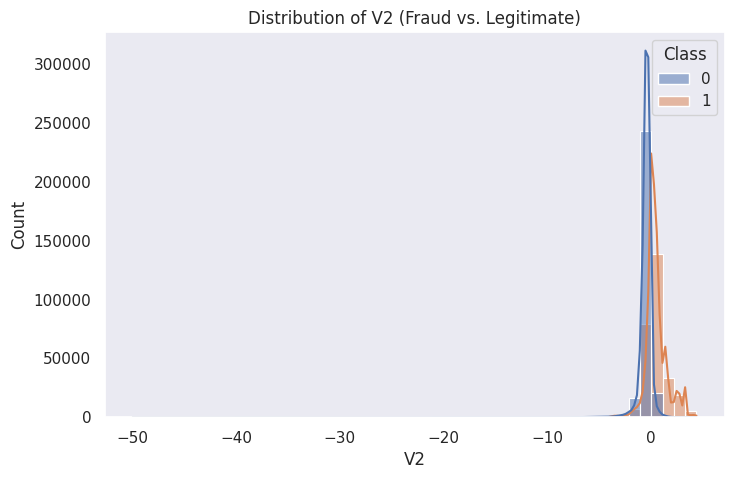

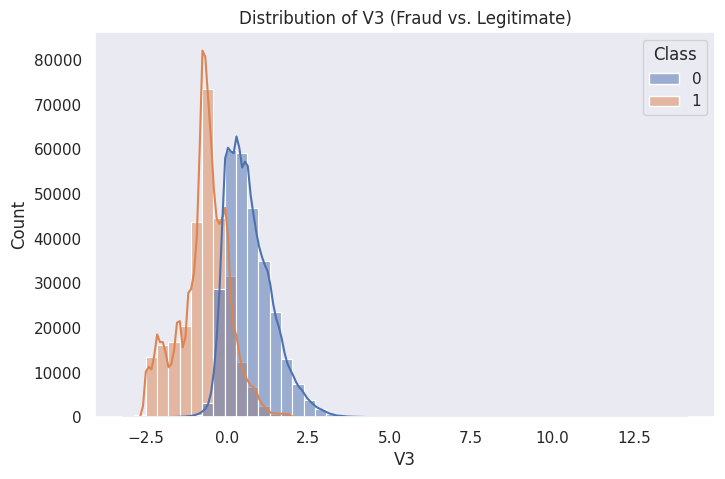

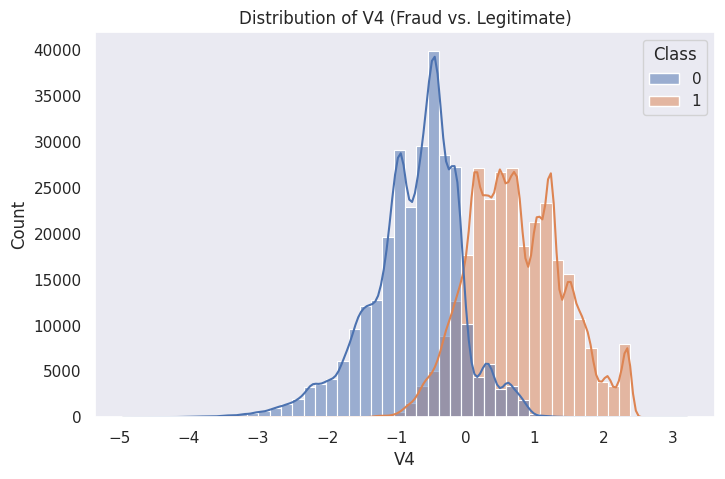

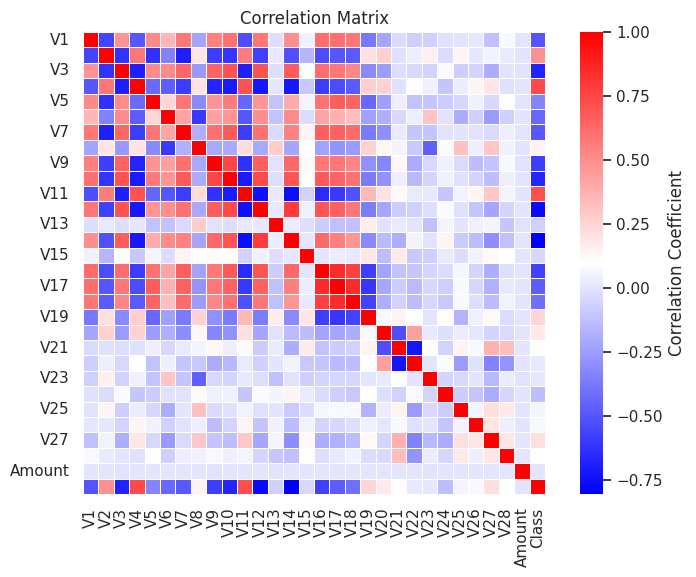

/tmp/ipython-input-582915165.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_class.values, y=correlation_with_class.index, palette='bwr', legend=False) # Add hue and set legend=False


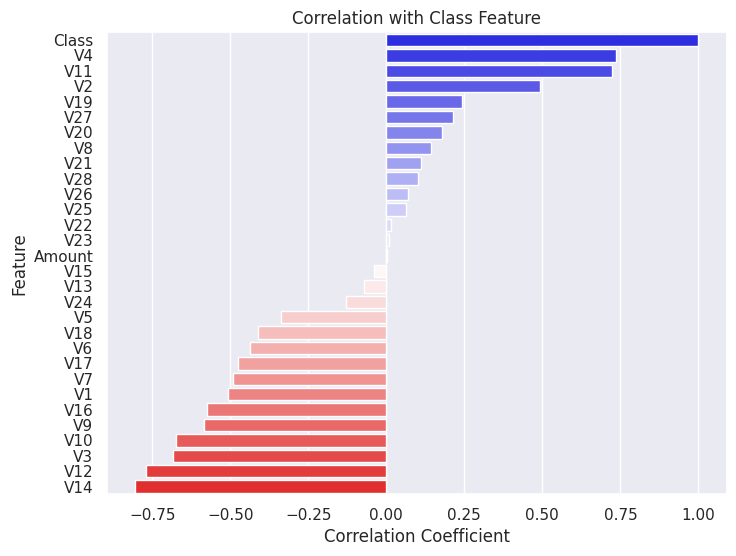

In [9]:
# Step 3: Descriptive Statistics and Initial Visualizations
print("\nDescriptive Statistics for Key Features:")
key_features = ['Amount', 'V1', 'V2']
stats = df[key_features + ['Class']].groupby('Class').agg(['mean', 'std'])
print(stats)

# Class distribution
print("\nClass Distribution:")
class_counts = df['Class'].value_counts(normalize=True) * 100
print(class_counts)

# Plot class distribution as a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="muted")
plt.title('Class Distribution (Fraud vs. Legitimate)')
plt.xlabel('Class (0: Legitimate, 1: Fraud)')
plt.ylabel('Percentage (%)')
plt.show()

sns.set_theme(style="dark")

# Draw a violinplot comparing fraud vs. legitimate transaction amounts
sns.violinplot(
    data=df,
    x="Class",
    y="Amount",
    hue="Class",
    split=False,
    inner="quart",
    fill=False,
    palette="muted"
)
# Add plot labels and title
plt.title("Transaction Amounts by Class (Fraud vs. Legitimate)")
plt.xlabel("Transaction Class")
plt.ylabel("Transaction Amount")
plt.show()

# Plot distribution of some V features
v_features_to_plot = ['V1', 'V2', 'V3', 'V4']
for feature in v_features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue='Class', bins=50, kde=True)
    plt.title(f'Distribution of {feature} (Fraud vs. Legitimate)')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Correlation Matrix Heatmap
plt.figure(figsize=(9, 6))
correlation_matrix = df.drop(['id'], axis=1).corr()
sns.set_theme()
sns.heatmap(
    correlation_matrix,
    annot=False,
    fmt=".2f",
    linewidths=".5",
    cmap='bwr',
    cbar_kws={'label': 'Correlation Coefficient'},
    square=True
)
plt.title('Correlation Matrix')
plt.show()

# Correlation with Class
plt.figure(figsize=(8, 6))
correlation_with_class = correlation_matrix['Class'].sort_values(ascending=False)
sns.barplot(x=correlation_with_class.values, y=correlation_with_class.index, palette='bwr', legend=False)
plt.title('Correlation with Class Feature')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

# **Step 4: Data Preprocessing**

In [10]:
# Remove duplicates
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale 'Amount' and other features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print class distribution before SMOTE
print("\nTraining Class Distribution Before SMOTE:")
print(y_train.value_counts())
# Use original training data since SMOTE is not needed
X_train_res, y_train_res = X_train, y_train

Shape after removing duplicates: (568630, 31)

Training Class Distribution Before SMOTE:
Class
0    227452
1    227452
Name: count, dtype: int64


# **Step 5: Define evaluation function**

In [45]:
def evaluate_model(model, X_test, y_test, model_name):
    try:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        print(f"\n{model_name} Performance:")
        auc_display = f"{str(auc):.4f}" if auc is not None else 'N/A'
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {auc_display}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # ROC Curve
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title('ROC Curve')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.show()

        return y_pred, y_prob, f1
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return None, None, None

# **Step 6: Train and Evaluate Models**


Logistic Regression Performance:
Error evaluating Logistic Regression: Invalid format specifier '.4f if auc is not None else 'N/A'' for object of type 'float'

Decision Tree Performance:
Error evaluating Decision Tree: Invalid format specifier '.4f if auc is not None else 'N/A'' for object of type 'float'


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9219 - loss: 0.1825 - val_accuracy: 0.9976 - val_loss: 0.0088
Epoch 2/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9978 - loss: 0.0089 - val_accuracy: 0.9988 - val_loss: 0.0045
Epoch 3/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9989 - loss: 0.0054 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 4/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 5/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 6/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 7/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 8/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.

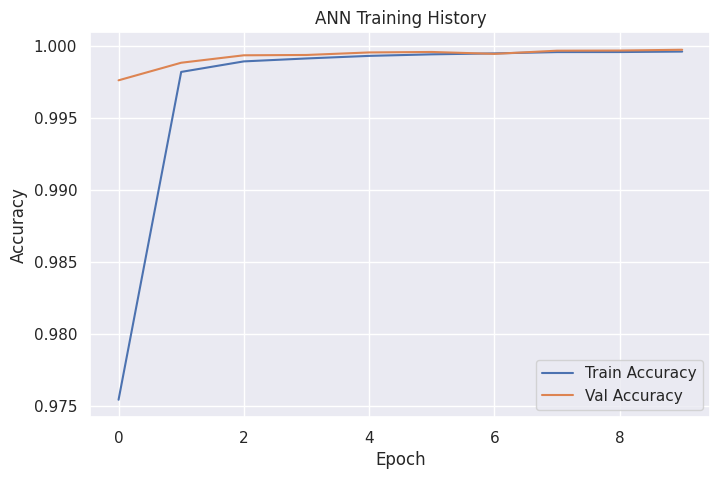

In [12]:
# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train_res, y_train_res)
f1_lr = evaluate_model(lr, X_test, y_test, 'Logistic Regression')

# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_res, y_train_res)
f1_dt = evaluate_model(dt, X_test, y_test, 'Decision Tree')

# Simplified ANN
try:
    ann = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = ann.fit(X_train_res, y_train_res, epochs=10, batch_size=512, validation_split=0.2, verbose=1)

    # Evaluate ANN
    y_prob_ann = ann.predict(X_test)
    y_pred_ann = (y_prob_ann > 0.5).astype(int)
    acc_ann = accuracy_score(y_test, y_pred_ann)
    prec_ann = precision_score(y_test, y_pred_ann, zero_division=0)
    rec_ann = recall_score(y_test, y_pred_ann, zero_division=0)
    f1_ann = f1_score(y_test, y_pred_ann, zero_division=0)
    auc_ann = roc_auc_score(y_test, y_prob_ann)

    print("\nANN Performance:")
    print(f"Accuracy: {acc_ann:.4f}, Precision: {prec_ann:.4f}, Recall: {rec_ann:.4f}, F1-Score: {f1_ann:.4f}, ROC-AUC: {auc_ann:.4f}")

    # Plot training history
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('ANN Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show('seaborn-v0_8')
except Exception as e:
    print(f"Error training/evaluating ANN: {e}")
    f1_ann = None

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
f1_dt = f1_score(y_test, y_pred_dt)

# ANN
ann = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)
ann.fit(X_train, y_train)
y_pred_ann = ann.predict(X_test)
f1_ann = f1_score(y_test, y_pred_ann)

print(f"F1-Scores: LR={f1_lr:.4f}, DT={f1_dt:.4f}, ANN={f1_ann:.4f}")

F1-Scores: LR=0.9983, DT=0.9996, ANN=0.9997


# **Step 7: Traditional Rule-Based Method**

In [ ]:
threshold_amount = df['Amount'].mean() + 3 * df['Amount'].std()
y_pred_rule = (X_test['Amount'] > threshold_amount).astype(int)
acc_rule = accuracy_score(y_test, y_pred_rule)
prec_rule = precision_score(y_test, y_pred_rule, zero_division=0)
rec_rule = recall_score(y_test, y_pred_rule, zero_division=0)
f1_rule = f1_score(y_test, y_pred_rule, zero_division=0)
auc_rule = roc_auc_score(y_test, y_pred_rule)

print("\nTraditional Rule-Based Performance:")
print(f"Accuracy: {acc_rule:.4f}, Precision: {prec_rule:.4f}, Recall: {rec_rule:.4f}, F1-Score: {f1_rule:.4f}, ROC-AUC: {auc_rule:.4f}")



Traditional Rule-Based Performance:
Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC-AUC: 0.5000


# **Step 8: Statistical Testing**


Statistical test skipped due to insufficient data or zero F1-score for the rule-based method.


/tmp/ipython-input-277170248.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


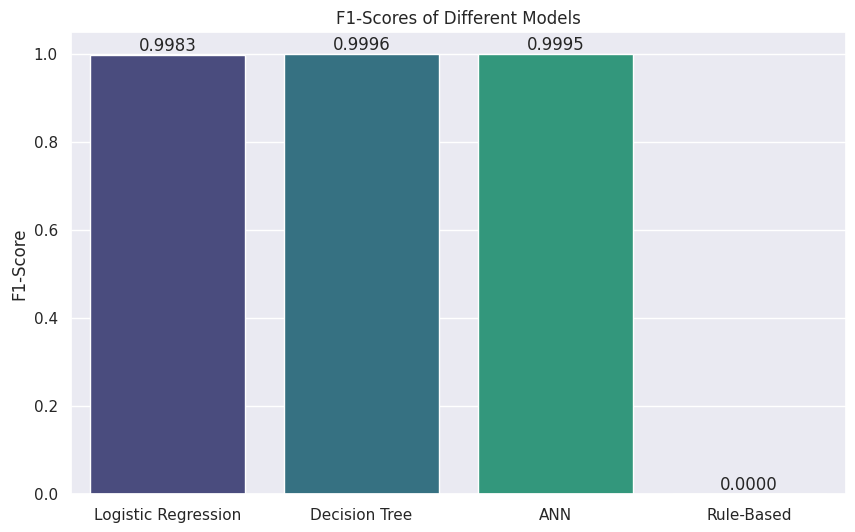

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import numpy as np

f1_scores_bda = [f1 for f1 in [f1_lr, f1_dt, f1_ann] if f1 is not None]
if f1_scores_bda and f1_rule is not None and f1_rule != 0.0:
    f1_scores_rule = [f1_rule] * len(f1_scores_bda)
    if len(f1_scores_bda) > 1 and np.var(f1_scores_bda) > 1e-9 and np.var(f1_scores_rule) > 1e-9:
        try:
            t_stat, p_value = ttest_rel(f1_scores_bda, f1_scores_rule)
            print(f"\nStatistical Test (F1-Score Comparison): t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
            if p_value < 0.05:
                print("Difference in performance is statistically significant.")
            else:
                 print("Difference in performance is not statistically significant.")
        except Exception as e:
            print(f"\nCould not perform statistical test: {e}")
    else:
        print("\nStatistical test skipped due to insufficient data or zero variance in F1-scores.")
else:
    print("\nStatistical test skipped due to insufficient data or zero F1-score for the rule-based method.")

# Add visualization for F1-scores
f1_scores_dict = {
    "Logistic Regression": f1_lr,
    "Decision Tree": f1_dt,
    "ANN": f1_ann,
    "Rule-Based": f1_rule
}

models = []
scores = []
for model, score in f1_scores_dict.items():
    if score is not None:
        models.append(model)
        scores.append(score)

if scores:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=scores, palette="viridis", hue=models, legend=False) # Added hue and legend=False
    plt.title("F1-Scores of Different Models")
    plt.ylabel("F1-Score")
    plt.ylim(0, 1.05)
    for i, score in enumerate(scores):
        plt.text(i, score + 0.01, f"{score:.4f}", ha='center')
    plt.show()
else:
    print("\nNo valid F1-scores to plot.")


Logistic Regression Performance:
Accuracy: 0.9983, Precision: 0.9990, Recall: 0.9976, F1-Score: 0.9983, ROC-AUC: 0.9998


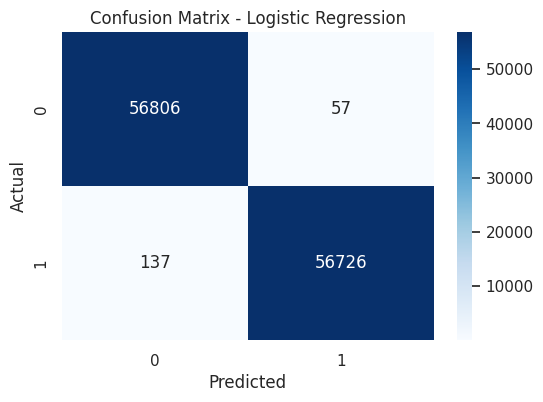

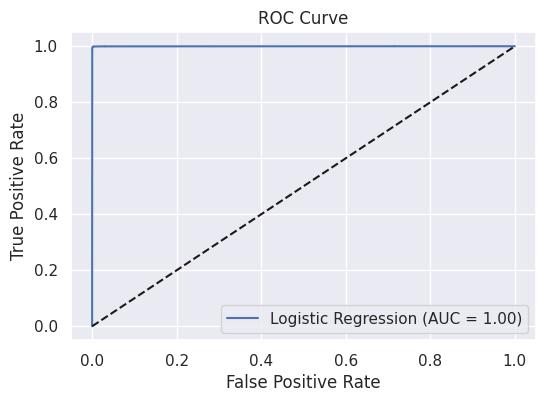


Decision Tree Performance:
Accuracy: 0.9996, Precision: 0.9997, Recall: 0.9996, F1-Score: 0.9996, ROC-AUC: 0.9999


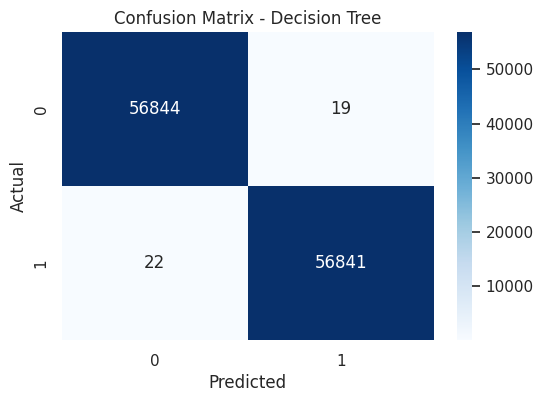

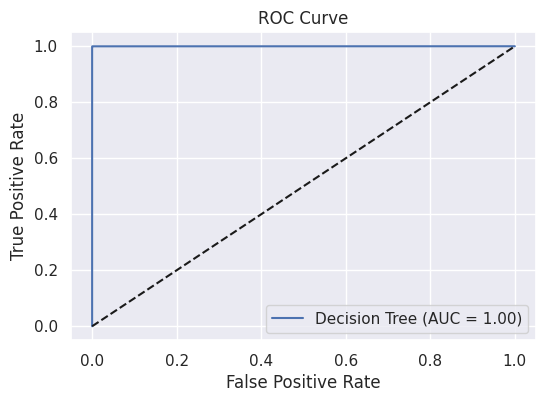

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9280 - loss: 0.1720 - val_accuracy: 0.9979 - val_loss: 0.0080
Epoch 2/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9980 - loss: 0.0080 - val_accuracy: 0.9991 - val_loss: 0.0045
Epoch 3/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9990 - loss: 0.0050 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 4/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 5/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 6/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 7/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9995 - val_loss: 0.0019
Epoch 8/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9995 - val_

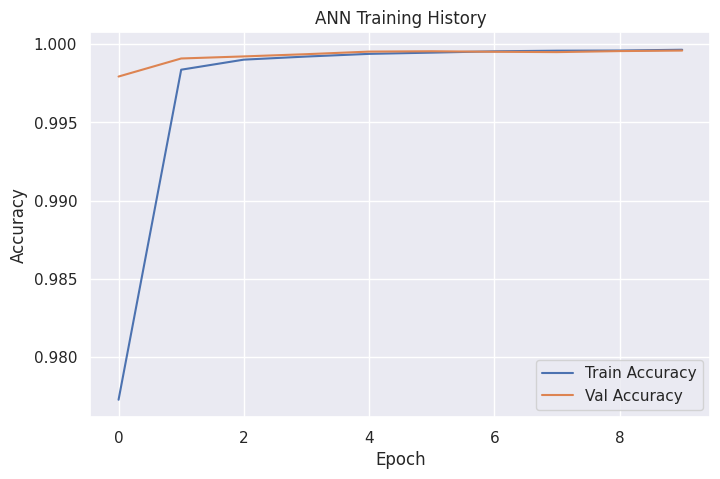

In [29]:
# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train_res, y_train_res)
y_pred_lr, y_prob_lr, f1_lr = evaluate_model(lr, X_test, y_test, 'Logistic Regression')

# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_res, y_train_res)
y_pred_dt, y_prob_dt, f1_dt = evaluate_model(dt, X_test, y_test, 'Decision Tree')

# Simplified ANN
try:
    ann = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = ann.fit(X_train_res, y_train_res, epochs=10, batch_size=512, validation_split=0.2, verbose=1)

    # Evaluate ANN
    y_prob_ann = ann.predict(X_test)
    y_pred_ann = (y_prob_ann > 0.5).astype(int)
    acc_ann = accuracy_score(y_test, y_pred_ann)
    prec_ann = precision_score(y_test, y_pred_ann, zero_division=0)
    rec_ann = recall_score(y_test, y_pred_ann, zero_division=0)
    f1_ann = f1_score(y_test, y_pred_ann, zero_division=0)
    auc_ann = roc_auc_score(y_test, y_prob_ann)

    print("\nANN Performance:")
    print(f"Accuracy: {acc_ann:.4f}, Precision: {prec_ann:.4f}, Recall: {rec_ann:.4f}, F1-Score: {f1_ann:.4f}, ROC-AUC: {auc_ann:.4f}")

    # Plot training history
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('ANN Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show('seaborn-v0_8')
except Exception as e:
    print(f"Error training/evaluating ANN: {e}")
    f1_ann = None